## Testing Speed of various approaches

In [1]:
import pathlib
import numpy as np
import cupy as cp
from cuml.manifold import UMAP as UMAP_cuml
from cuml.cluster import HDBSCAN as HDBSCAN_cuml
from tqdm.auto import tqdm
import time

# --- Constants ---
ROOT = pathlib.Path().resolve().parent  # Go up one directory
NPZ_DIR = ROOT / "files"
PROCESSED_DIR = ROOT / "files_with_teacher_labels"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_FILES = [
    "llb3_fold1.npz", "llb3_fold2.npz", "llb3_fold3.npz", "llb3_fold4.npz",
    "llb11_fold1.npz", "llb11_fold2.npz", "llb11_fold3.npz", "llb11_fold4.npz",
    "llb16_fold1.npz", "llb16_fold2.npz", "llb16_fold3.npz", "llb16_fold4.npz",
]
MAX_FRAMES = 1_000_000

# --- Load all embeddings ---
all_embeddings = []
fold_lengths = []
for fname in RAW_FILES:
    in_path = NPZ_DIR / fname
    with np.load(in_path) as f:
        embeddings = f["predictions"][:MAX_FRAMES]
        all_embeddings.append(embeddings)
        fold_lengths.append(len(embeddings))

# --- Fit UMAP on the first fold ---
print("Fitting UMAP on the first fold...")
embeddings_first = all_embeddings[0]
emb_eval_gpu_first = cp.asarray(embeddings_first)
umap_cuml = UMAP_cuml(n_neighbors=50, n_components=8, min_dist=0.1, metric="euclidean", init="spectral", n_epochs=200)
z_umap_first = umap_cuml.fit_transform(emb_eval_gpu_first)

# --- Concatenate all embeddings ---
print("Concatenating all embeddings for transform...")
all_embeddings_concat = np.concatenate(all_embeddings, axis=0)
all_embeddings_gpu = cp.asarray(all_embeddings_concat)

# --- Transform all data and time each data point ---
print("Transforming all data and timing each data point...")
transform_times = []
z_umap_all = np.empty((all_embeddings_concat.shape[0], 8), dtype=np.float32)
batch_size = 1024  # Use a batch size for efficiency

start_idx = 0
while start_idx < all_embeddings_concat.shape[0]:
    end_idx = min(start_idx + batch_size, all_embeddings_concat.shape[0])
    batch = all_embeddings_gpu[start_idx:end_idx]
    t0 = time.perf_counter()
    z_umap_batch = umap_cuml.transform(batch)
    t1 = time.perf_counter()
    z_umap_all[start_idx:end_idx] = cp.asnumpy(z_umap_batch)
    # Record per-point time for this batch
    per_point_time = (t1 - t0) / (end_idx - start_idx)
    transform_times.extend([per_point_time] * (end_idx - start_idx))
    start_idx = end_idx

# --- Write per-point transform times to a txt file ---
txt_path = PROCESSED_DIR / "umap_transform_times.txt"
with open(txt_path, "w") as f:
    for t in transform_times:
        f.write(f"{t:.8f}\n")

print("UMAP transform timing complete. Times written to", txt_path)

/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting UMAP on the first fold...
Concatenating all embeddings for transform...
Transforming all data and timing each data point...
[2025-06-10 12:55:54.849] [CUML] [info] Transform can only be run with brute force. Using brute force.
UMAP transform timing complete. Times written to /home/george-vengrovski/Documents/projects/tweety_bert_paper/files_with_teacher_labels/umap_transform_times.txt


## Creating Fit + Transform Figures

In [3]:
import pathlib
import numpy as np
import cupy as cp
from cuml.manifold import UMAP as UMAP_cuml
import matplotlib.pyplot as plt

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files_with_teacher_labels"
SAVE_DIR = ROOT / "results"
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Pick a bird and two folds
BIRD = "llb3"
FOLD_FIT_IDX = 0
FOLD_TRANSFORM_IDX = 1

FOLD_FILES = [
    f"{BIRD}_fold1.npz",
    f"{BIRD}_fold5.npz",
]
# Using a larger N since this will be fast now
MAX_FRAMES = 1_000_000

# --- Load embeddings and labels for the two folds ---
in_path_fit = NPZ_DIR / FOLD_FILES[FOLD_FIT_IDX]
in_path_transform = NPZ_DIR / FOLD_FILES[FOLD_TRANSFORM_IDX]

with np.load(in_path_fit) as f:
    embeddings_fit = f["predictions"][:MAX_FRAMES]
    labels_fit = f["ground_truth_labels"][:MAX_FRAMES]
with np.load(in_path_transform) as f:
    embeddings_transform = f["predictions"][:MAX_FRAMES]
    labels_transform = f["ground_truth_labels"][:MAX_FRAMES]

# --- Fit UMAP on the first fold ---
print("Fitting UMAP on fold:", FOLD_FILES[FOLD_FIT_IDX])
emb_fit_gpu = cp.asarray(embeddings_fit)
umap_cuml = UMAP_cuml(n_neighbors=50, n_components=2, min_dist=0.1, metric="euclidean", init="spectral", n_epochs=200)
# The fit_transform output is already a cupy array
z_umap_fit = umap_cuml.fit_transform(emb_fit_gpu)

# --- Transform the second fold using the fitted UMAP ---
print("Transforming fold:", FOLD_FILES[FOLD_TRANSFORM_IDX])
emb_transform_gpu = cp.asarray(embeddings_transform)
# The transform output is also already a cupy array
z_umap_transform = umap_cuml.transform(emb_transform_gpu)

z_umap_fit_np = cp.asnumpy(z_umap_fit)
z_umap_transform_np = cp.asnumpy(z_umap_transform)

# --- Save UMAP coordinates and labels for both folds ---

np.savez(SAVE_DIR / "fit_umap_train.npz", coords=z_umap_fit_np, labels=labels_fit)

np.savez(SAVE_DIR / "transform_umap_test.npz", coords=z_umap_transform_np, labels=labels_transform)

Fitting UMAP on fold: llb3_fold1.npz
[2025-06-11 12:51:59.695] [CUML] [info] Building knn graph using nn descent
Transforming fold: llb3_fold5.npz
[2025-06-11 12:52:11.785] [CUML] [info] Transform can only be run with brute force. Using brute force.


## Compare Logits on held out set 

In [1]:
import sys
import pathlib
import shutil
import time
import gc
from collections import Counter
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from umap import UMAP

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files_with_teacher_labels"
SAVE_DIR = ROOT / "results" / "decoder_softmax_umap" # Changed save dir
if SAVE_DIR.exists():
    shutil.rmtree(SAVE_DIR) # Clean up previous runs
SAVE_DIR.mkdir(parents=True)

MAX_FRAMES = 1_000_000
CTX = 1_000
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = ROOT / "experiments" / "TweetyBERT_Paper_Yarden_Model"

# --- helpers: i/o + tiny utils ---
def load_npz(fp: pathlib.Path) -> Tuple[np.ndarray, ...]:
    with np.load(fp) as f:
        return ( # Return spectrograms, teacher labels, and ground truth
            f["s"][:MAX_FRAMES],
            f["hdbscan_labels"][:MAX_FRAMES],
            f["ground_truth_labels"][:MAX_FRAMES],
        )

# --- helpers: decoder forward ---
sys.path.insert(0, str(pathlib.Path("src").resolve()))
from src.decoder import TweetyBertClassifier,SongDataSet_Image, CollateFunction

## For evalulation of decoder performance
def run_decoder(model_torch: torch.nn.Module,
                specs: np.ndarray,
                gt: np.ndarray,
                tmp_dir: pathlib.Path) -> Tuple[np.ndarray, float, np.ndarray]:
    tmp_dir.mkdir(parents=True, exist_ok=True)
    seg_id = 0
    for start in range(0, len(specs), CTX):
        seg = specs[start:start + CTX]
        seg = np.pad(seg, ((0, 0), (20, 0)), constant_values=0)
        if seg.shape[0] < CTX:
            seg = np.pad(seg, ((0, CTX - seg.shape[0]), (0, 0)))
        gt_seg = gt[start:start + CTX]
        if gt_seg.shape[0] < CTX:
            gt_seg = np.pad(gt_seg, (0, CTX - gt_seg.shape[0]))
        # write the slice so the dataset isn't empty
        np.savez(
            tmp_dir / f"{seg_id}.npz",
            labels=gt_seg,
            s=seg.T,                        # freq × time, per decoder expectations
            vocalization=np.zeros(CTX, dtype=np.int8)
        )
        seg_id += 1

    if seg_id == 0:
        raise RuntimeError("no segments saved – tmp_dir empty")

    ds = SongDataSet_Image(tmp_dir,
                           num_classes=int(gt.max()) + 1,
                           segment_length=CTX,
                           infinite_loader=False)
    dl = DataLoader(ds, batch_size=1, shuffle=False,
                    collate_fn=CollateFunction(segment_length=CTX))

    preds, logits_accum, gts_accum = [], [], []
    t0 = time.perf_counter()
    model_torch.eval()
    with torch.no_grad():
        for b in dl:
            s = b[0].to(DEV)           # first element = spectrogram tensor
            gt = b[1].to(DEV)
            logits = model_torch(s)          # (1, S, C)
            preds.append(torch.argmax(logits, 2).cpu().numpy())
            logits_accum.append(logits.cpu().numpy())        # (1, S, C)
            gts_accum.append(torch.argmax(gt, 2).cpu().numpy())

    t_elapsed = time.perf_counter() - t0

    shutil.rmtree(tmp_dir, ignore_errors=True)
    preds   = np.concatenate([p.squeeze(0) for p in preds])[:len(specs)]
    logits  = np.concatenate([l.squeeze(0) for l in logits_accum])[:len(specs)]
    gts     = np.concatenate([g.squeeze(0) for g in gts_accum])[:len(specs)]

    return preds, t_elapsed, logits, gts 

# --- driver ---
if __name__ == "__main__":
    # --- 1. Configuration ---
    BIRD_ID = 'llb3'
    TRAIN_FILE = f'{BIRD_ID}_fold1.npz'
    TEST_FILE = f'{BIRD_ID}_fold5.npz'
    DECODER_CONFIG = {'name': 'mlp_weighted', 'classifier_type': 'decoder', 'use_weights': True}
    print("--- Configuration ---")
    print(f"Bird: {BIRD_ID}, Train on: {TRAIN_FILE}, Test on: {TEST_FILE}")

    # --- 2. Train Decoder on Fold 1 ---
    fit_path = NPZ_DIR / TRAIN_FILE
    _, teacher_labels, _ = load_npz(fit_path)
    num_classes = int(teacher_labels.max()) + 1
    label_counts = Counter(teacher_labels)
    class_counts = np.array([label_counts.get(i, 0) for i in range(num_classes)])
    class_counts[class_counts == 0] = 1 # Avoid division by zero
    _class_weights = 1.0 / class_counts
    _class_weights /= _class_weights.sum() / num_classes
    _class_weights = torch.tensor(_class_weights, dtype=torch.float32, device=DEV)

    print("\n--- Training Decoder ---")
    probe = TweetyBertClassifier(
        model_dir=str(MODEL_DIR),
        linear_decoder_dir=str(SAVE_DIR / "tmp_decoder"),
        context_length=CTX,
        classifier_type=DECODER_CONFIG['classifier_type'],
        weight=_class_weights if DECODER_CONFIG['use_weights'] else None
    )
    probe.prepare_data(str(fit_path), test_train_split=0.8)
    probe.create_dataloaders(batch_size=128)
    probe.create_classifier()
    probe.train_classifier(lr=3e-4, desired_total_batches=500, batches_per_eval=50, patience=6)
    probe_model = probe.classifier_model.to(DEV)

    # --- 3. Run Inference on Train and Test Folds to Get Logits ---
    print("\n--- Running Inference ---")
    specs_train, _, gt_train = load_npz(fit_path)
    specs_test, _, gt_test = load_npz(NPZ_DIR / TEST_FILE)

    _, _, logits_train, gt_train = run_decoder(probe_model, specs_train, gt_train, SAVE_DIR / "tmp_train")
    _, _, logits_test, gt_test = run_decoder(probe_model, specs_test, gt_test, SAVE_DIR / "tmp_test")

    # Convert logits to softmax probabilities
    # softmax_train = F.softmax(torch.from_numpy(logits_train), dim=-1).numpy()
    # softmax_test = F.softmax(torch.from_numpy(logits_test), dim=-1).numpy()
    softmax_train = logits_train
    softmax_test = logits_test

    n_umap = 1_000_000
    softmax_train_sub = softmax_train[:min(n_umap, len(softmax_train))]
    softmax_test_sub = softmax_test[:min(n_umap, len(softmax_test))]
    gt_train_sub = gt_train[:min(n_umap, len(gt_train))]
    gt_test_sub = gt_test[:min(n_umap, len(gt_test))]

    # Save softmax_train_sub and gt_train_sub instead of UMAP coords
    np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/" + "decoder_umap_train.npz", softmax=softmax_train_sub, colors=gt_train_sub)

    # Save softmax_test_sub and gt_test_sub instead of UMAP coords
    np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/" + "decoder_umap_test.npz", softmax=softmax_test_sub, colors=gt_test_sub)

    # --- 5. Cleanup ---
    shutil.rmtree(SAVE_DIR, ignore_errors=True)
    probe_model.to('cpu')
    del probe_model, probe, logits_train, logits_test, softmax_train, softmax_test, softmax_train_sub, softmax_test_sub, gt_train_sub, gt_test_sub
    torch.cuda.empty_cache()
    gc.collect()

2025-06-12 10:38:55.994731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 10:38:56.019820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


--- Configuration ---
Bird: llb3, Train on: llb3_fold1.npz, Test on: llb3_fold5.npz

--- Training Decoder ---
Step 50: Train Loss 2.1900 FER = 30.72%, Val Loss = 2.2041
Step 100: Train Loss 0.9032 FER = 10.77%, Val Loss = 1.9796
Step 150: Train Loss 0.6388 FER = 8.43%, Val Loss = 1.4945
Step 200: Train Loss 0.4262 FER = 9.21%, Val Loss = 0.6559
Step 250: Train Loss 0.3154 FER = 5.63%, Val Loss = 0.6732
Step 300: Train Loss 0.2513 FER = 4.54%, Val Loss = 0.2962
Step 350: Train Loss 0.1787 FER = 4.99%, Val Loss = 0.6444
Step 400: Train Loss 0.2662 FER = 5.33%, Val Loss = 1.4261
Step 450: Train Loss 0.2511 FER = 4.52%, Val Loss = 1.2799
Step 500: Train Loss 0.2077 FER = 5.62%, Val Loss = 1.1984

--- Running Inference ---


In [1]:
import numpy as np
from cuml.manifold import UMAP
import matplotlib.pyplot as plt

train_data = np.load("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_train.npz")
test_data = np.load("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_test.npz")

softmax_train_sub = train_data["softmax"]
softmax_test_sub = test_data["softmax"]
labels_train = train_data["colors"]
labels_test = test_data["colors"]

# Cap at 100k points
cap = 1_000_000
softmax_train_sub = softmax_train_sub[:cap]
labels_train = labels_train[:cap]
softmax_test_sub = softmax_test_sub[:cap]
labels_test = labels_test[:cap]

build_kwds = {"nnd_graph_degree": 256,
              "nnd_intermediate_graph_degree": 256,
              "build_algo": "brute_force_knn"}  # Default value for nnd_graph_degree


umap_model = UMAP(
    n_neighbors=50,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    init="spectral",
    build_kwds=build_kwds,
    output_type='numpy'
)

umap_train = umap_model.fit_transform(softmax_train_sub)
umap_test = umap_model.fit_transform(softmax_test_sub)

# # Save UMAP coords and labels as npz files
np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_train_coords.npz", coords=umap_train, labels=labels_train)
np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_test_coords.npz", coords=umap_test, labels=labels_test)


## 4 panel plot

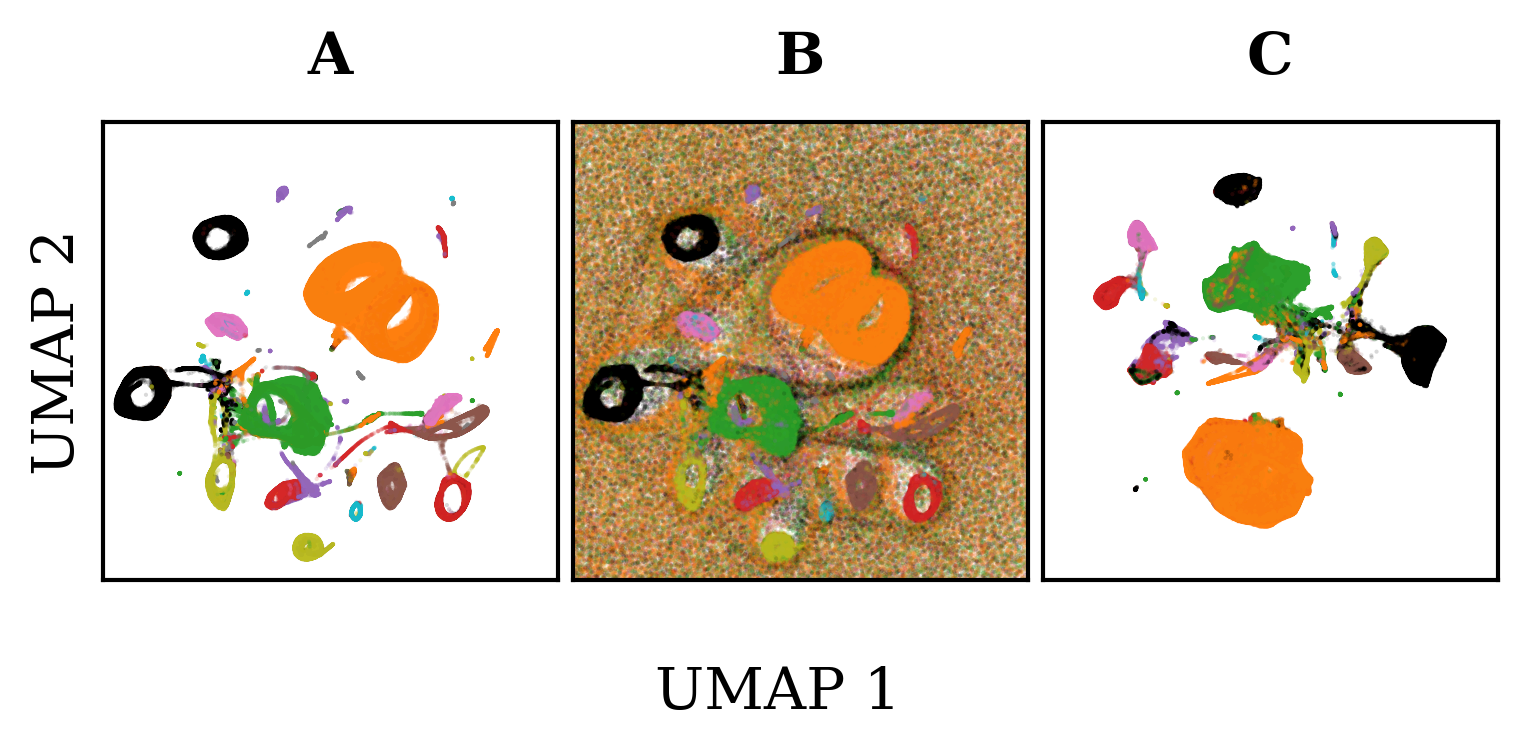

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid

def syllable_to_phrase_labels(arr, silence=0):
    new_arr = np.array(arr, dtype=int)
    length = len(new_arr)
    if length == 0:
        return new_arr
    def find_silence_runs(labels):
        runs = []
        in_silence = False
        start = None
        for i, val in enumerate(labels):
            if val == silence and not in_silence:
                in_silence = True
                start = i
            elif val != silence and in_silence:
                runs.append((start, i - 1))
                in_silence = False
        if in_silence:
            runs.append((start, length - 1))
        return runs
    silence_runs = find_silence_runs(new_arr)
    for start_idx, end_idx in silence_runs:
        left_label = new_arr[start_idx - 1] if start_idx > 0 else None
        right_label = new_arr[end_idx + 1] if end_idx < length - 1 else None
        if left_label is None and right_label is None:
            continue
        elif left_label is None:
            new_arr[start_idx:end_idx+1] = right_label
        elif right_label is None:
            new_arr[start_idx:end_idx+1] = left_label
        elif left_label == right_label:
            new_arr[start_idx:end_idx+1] = left_label
        else:
            for i in range(start_idx, end_idx + 1):
                dist_left = i - (start_idx - 1)
                dist_right = (end_idx + 1) - i
                if dist_left < dist_right:
                    new_arr[i] = left_label
                elif dist_right < dist_left:
                    new_arr[i] = right_label
                else:
                    new_arr[i] = left_label
    return new_arr

ROOT = pathlib.Path().resolve()
RESULTS_DIR = ROOT / "results"

npz_files = [
    RESULTS_DIR / "fit_umap_train.npz",
    RESULTS_DIR / "transform_umap_test.npz", 
    RESULTS_DIR / "decoder_umap_test_coords.npz"
]

tab10 = plt.get_cmap('tab10')
colors_list = ['black'] + [tab10(i) for i in range(1, 10)]
custom_cmap = mpl.colors.ListedColormap(colors_list)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Computer Modern Roman", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1,
})

fig = plt.figure(figsize=(6., 2.5), dpi=300)
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 3),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode=None,
                 )

panel_labels = ['A', 'B', 'C']

# Do not scale the UMAPs: let each fill its own box
for ax, npz_file, panel_label in zip(grid, npz_files, panel_labels):
    if npz_file.exists():
        data = np.load(npz_file)
        coords = data['coords']
        if 'colors' in data:
            colors = data['colors']
        elif 'labels' in data:
            colors = data['labels']
        else:
            colors = 'black'
        if not isinstance(colors, str):
            colors = syllable_to_phrase_labels(colors)
        if isinstance(colors, str):
            ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=1, alpha=0.15, linewidths=0)
        else:
            ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=1, alpha=0.15, cmap=custom_cmap, linewidths=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        # Set axis limits to the min/max of the data for each panel
        x_min, x_max = np.min(coords[:, 0]), np.max(coords[:, 0])
        y_min, y_max = np.min(coords[:, 1]), np.max(coords[:, 1])
        # Add a small margin
        x_pad = (x_max - x_min) * 0.15
        y_pad = (y_max - y_min) * 0.15
        ax.set_xlim(x_min - x_pad, x_max + x_pad)
        ax.set_ylim(y_min - y_pad, y_max + y_pad)
    else:
        ax.text(0.5, 0.5, f'File not found:\n{npz_file.name}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

grid[0].set_ylabel('UMAP 2', fontsize=14)
fig.text(0.5, 0.04, 'UMAP 1', ha='center', va='center', fontsize=14)

for ax, panel_label in zip(grid, panel_labels):
    ax.annotate(
        panel_label,
        xy=(0.5, 1.08), xycoords='axes fraction',
        ha='center', va='bottom',
        fontsize=14, fontweight='bold'
    )

plt.show()